# modeling by factors

In [1]:
import os
print(os.getcwd())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


c:\Users\junio\OneDrive\바탕 화면\dacon_elec


In [2]:
# loss function : SMAPE 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer # customize loss function

def smape(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    return np.mean((np.abs(true-pred))/(np.abs(true)+np.abs(pred)))*100
SMAPE = make_scorer(smape, greater_is_better=False)


In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
building_info = pd.read_csv('./data/building_info.csv')

# 요일 
train['time_'] = pd.to_datetime(train['일시'])
train['weekday'] = train['time_'].dt.weekday
train.drop(['time_'],axis=1, inplace=True)
test['time_'] = pd.to_datetime(test['일시'])
test['weekday'] = test['time_'].dt.weekday
test.drop(['time_'],axis=1, inplace=True)

train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))
test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))

train.drop(columns=['일시','num_date_time'], axis=1, inplace=True)
test.drop(columns=['일시','num_date_time'], axis=1, inplace=True)

col={'건물번호':'building_number',
                            '일시':'date_time',
                            '기온(C)':'temperature',
                            '강수량(mm)':'rainfall',
                            '풍속(m/s)':'windspeed',
                            '습도(%)':'humidity',
                            '일조(hr)':'sunshine',
                            '일사(MJ/m2)':'solar_radiation',
                            '전력소비량(kWh)':'power_consumption'}
train=train.rename(columns=col)
test=test.rename(columns=col)

building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}
building_info['building_type'] = building_info['building_type'].replace(translation_dict)
print(building_info.building_type.unique())

train_m=pd.merge(train,building_info, on="building_number",how="left")
test_m=pd.merge(test,building_info, on="building_number",how="left")
train_m = train_m.fillna(0)
# rainfall = train_m[['rainfall']].fillna(0)
# train_m.drop(['rainfall'],axis=1,inplace=True)
# train_m = pd.concat([train_m, rainfall],axis=1)

train_solar_power = train_m.drop(train_m[train_m['solar_power_capacity']=='-'].index)
train_ess = train_m.drop(train_m[train_m['ess_capacity']=='-'].index)
train_pcs = train_m.drop(train_m[train_m['pcs_capacity']=='-'].index)

# train_sunshine = train_m.drop(train_m[train_m['sunshine'].isna()==True].index)
# train_solar_radiation = train_m.drop(train_m[train_m['solar_radiation'].isna()==True].index)

['Other Buildings' 'Public' 'University' 'Data Center'
 'Department Store and Outlet' 'Hospital' 'Commercial' 'Apartment'
 'Research Institute' 'Knowledge Industry Center' 'Discount Mart'
 'Hotel and Resort']


In [4]:
train_m.head()

,building_number,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,weekday,month,day,time,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,2,6,1,0,Other Buildings,110634.0,39570.0,-,-,-
1,1,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,2,6,1,1,Other Buildings,110634.0,39570.0,-,-,-
2,1,17.7,0.0,1.5,45.0,0.0,0.0,974.88,2,6,1,2,Other Buildings,110634.0,39570.0,-,-,-
3,1,16.7,0.0,1.4,48.0,0.0,0.0,953.76,2,6,1,3,Other Buildings,110634.0,39570.0,-,-,-
4,1,18.4,0.0,2.8,43.0,0.0,0.0,986.40,2,6,1,4,Other Buildings,110634.0,39570.0,-,-,-


In [5]:
test_m.head()

,building_number,temperature,rainfall,windspeed,humidity,weekday,month,day,time,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,23.5,0.0,2.2,72,3,8,25,0,Other Buildings,110634.0,39570.0,-,-,-
1,1,23.0,0.0,0.9,72,3,8,25,1,Other Buildings,110634.0,39570.0,-,-,-
2,1,22.7,0.0,1.5,75,3,8,25,2,Other Buildings,110634.0,39570.0,-,-,-
3,1,22.1,0.0,1.3,78,3,8,25,3,Other Buildings,110634.0,39570.0,-,-,-
4,1,21.8,0.0,1.0,77,3,8,25,4,Other Buildings,110634.0,39570.0,-,-,-


### 1.1 building type

<Axes: xlabel='building_type'>

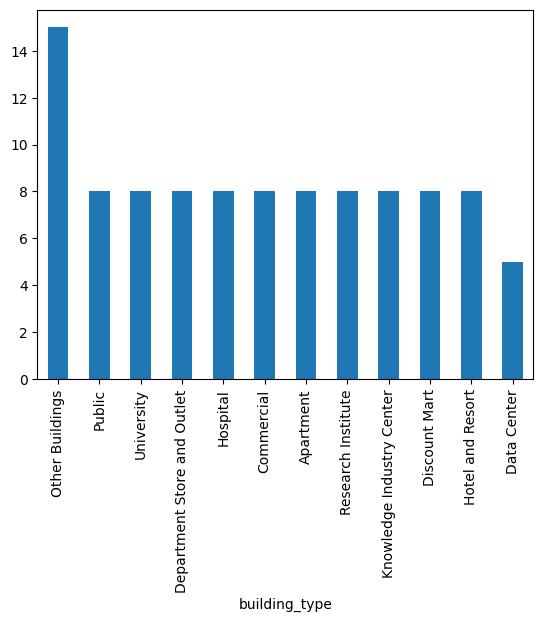

In [6]:
building_info['building_type'].value_counts().plot(kind='bar')

In [7]:
# building_info.building_type.unique().tolist()
# train_m[train_m['building_type']=='Public']

for building_type in building_info.building_type.unique().tolist():
    globals()['train_m_{}'.format(building_type)] = train_m[train_m['building_type']==building_type]
    globals()['test_m_{}'.format(building_type)] = test_m[test_m['building_type']==building_type]

In [8]:
train_m_Apartment.head()

,building_number,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,weekday,month,day,time,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
122400,61,18.6,0.0,0.9,42.0,0.0,0.0,2298.60,2,6,1,0,Apartment,667131.0,539213.0,-,-,-
122401,61,18.0,0.0,1.1,45.0,0.0,0.0,1891.08,2,6,1,1,Apartment,667131.0,539213.0,-,-,-
122402,61,17.7,0.0,1.5,45.0,0.0,0.0,1653.48,2,6,1,2,Apartment,667131.0,539213.0,-,-,-
122403,61,16.7,0.0,1.4,48.0,0.0,0.0,1561.68,2,6,1,3,Apartment,667131.0,539213.0,-,-,-
122404,61,18.4,0.0,2.8,43.0,0.0,0.0,1546.92,2,6,1,4,Apartment,667131.0,539213.0,-,-,-


### 1.2 building_number

In [9]:
for building_number in range(1,101):
    globals()['train_m_{}'.format(building_number)] = train_m[train_m['building_number']==building_number]
    globals()['test_m_{}'.format(building_number)] = test_m[test_m['building_number']==building_number]

In [10]:
train_mm = train_m.drop(['solar_power_capacity','ess_capacity','pcs_capacity'],axis=1)
# (1) 건물별 시간별 전기소비량 평균 
power_hour_mean = pd.pivot_table(train_mm, values='power_consumption', index=['building_number','time'],aggfunc = np.mean).reset_index()
from tqdm import tqdm
tqdm.pandas()
train_mm['hour_mean'] = train_mm.progress_apply(lambda x: power_hour_mean.loc[(power_hour_mean.building_number == x['building_number']) & (power_hour_mean.time == x['time']), 'power_consumption'].values[0],axis=1)

100%|██████████| 204000/204000 [01:16<00:00, 2651.81it/s]


In [11]:
# (2) 건물별 시간별 전기소비량 표준편차 
power_hour_std = pd.pivot_table(train_mm, values='power_consumption', index=['building_number','time'],aggfunc = np.std).reset_index()
tqdm.pandas()
train_mm['hour_std'] = train_mm.progress_apply(lambda x: power_hour_std.loc[(power_hour_std.building_number == x['building_number']) & (power_hour_std.time == x['time']), 'power_consumption'].values[0],axis=1)

  0%|          | 0/204000 [00:00<?, ?it/s]

100%|██████████| 204000/204000 [01:15<00:00, 2716.13it/s]


In [12]:
# (3) 건물별 요일별 시간별 전기소비량 평균
power_day_mean = pd.pivot_table(train_mm, values='power_consumption', index=['building_number','weekday','time'],aggfunc = np.mean).reset_index()
tqdm.pandas()
train_mm['day_mean'] = train_mm.progress_apply(lambda x: power_day_mean.loc[(power_day_mean.building_number == x['building_number']) & (power_day_mean.time == x['time']) & (power_day_mean.weekday == x['weekday']), 'power_consumption'].values[0],axis=1)

100%|██████████| 204000/204000 [01:52<00:00, 1805.37it/s]


In [13]:
# (4) 건물별 요일별 시간별 전기소비량 표준편차
power_day_std = pd.pivot_table(train_mm, values='power_consumption', index=['building_number','weekday','time'],aggfunc = np.std).reset_index()
tqdm.pandas()
train_mm['day_std'] = train_mm.progress_apply(lambda x: power_day_std.loc[(power_day_std.building_number == x['building_number']) & (power_day_std.time == x['time']) & (power_day_std.weekday == x['weekday']), 'power_consumption'].values[0],axis=1)

100%|██████████| 204000/204000 [01:52<00:00, 1805.79it/s]


In [14]:
train_mm['cooling_area_percentage'] = train_mm['cooling_area']/train_mm['total_area']

In [16]:
train_mm.to_csv('./train_mm_building_num.csv')

In [30]:
# including train, validation set. except test set
y = train_mm.loc[train_mm.building_number == 1, 'power_consumption']
x = train_mm.loc[train_mm.building_number == 1].drop(['power_consumption'],axis=1)

In [32]:
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X=x, test_size = 408) # 17일 * 24시간
print(x_train.shape, y_train.shape)

(1632, 19) (1632,)


<Axes: >

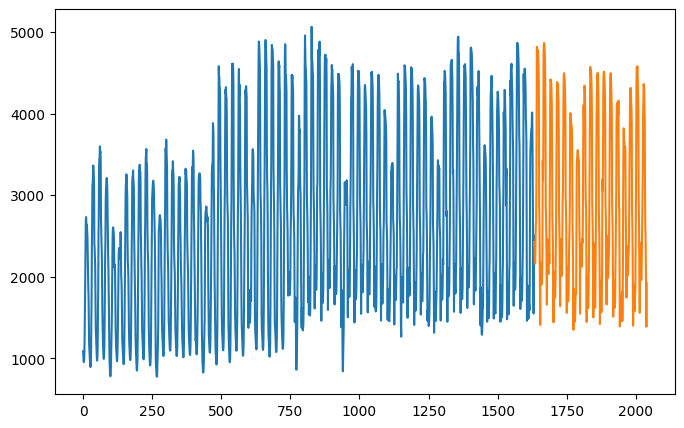

In [38]:
plt.figure(figsize=(8,5))
y_train.plot()
y_valid.plot()

# Modeling

In [ ]:
def weighted_mse(alpha=1):
    def weighted_mse_fixed(label, pred):
        residual = (label-pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad,hess
    return weighted_mse_fixed